## Project: Predicting Hazardous NEOs (Nearest Earth Objects)
### Table of Contents
* Data Import & Cleaning
* Exploratory Data Analysis (EDA)
* Preprocessing & Handling Imbalance
* Model Training & Evaluation
    - Logistic Regression
    - Random Forest Classifier

# Data Import & Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset
data = pd.read_csv("/kaggle/input/nasa-nearest-earth-objects-1910-2024/nearest-earth-objects(1910-2024).csv") 

data.shape

(338199, 9)

In [3]:
data.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


In [4]:
# Display basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB


In [5]:
data.describe()

,neo_id,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
count,3.381990e+05,338171.000000,338171.000000,338171.000000,338199.000000,3.381990e+05
mean,1.759939e+07,22.932525,0.157812,0.352878,51060.662908,4.153535e+07
std,2.287225e+07,2.911216,0.313885,0.701869,26399.238435,2.077399e+07
min,2.000433e+06,9.250000,0.000511,0.001143,203.346433,6.745533e+03
25%,3.373980e+06,20.740000,0.025384,0.056760,30712.031471,2.494540e+07
50%,3.742127e+06,22.800000,0.073207,0.163697,47560.465474,4.332674e+07
75%,5.405374e+07,25.100000,0.189041,0.422708,66673.820614,5.933961e+07
max,5.446281e+07,33.580000,37.545248,83.953727,291781.106613,7.479865e+07


In [6]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 absolute_magnitude        28
estimated_diameter_min    28
estimated_diameter_max    28
dtype: int64


In [7]:
# Handle missing values by filling with the mean for numerical columns
data['absolute_magnitude'].fillna(data['absolute_magnitude'].mean(), inplace=True)
data['estimated_diameter_min'].fillna(data['estimated_diameter_min'].mean(), inplace=True)
data['estimated_diameter_max'].fillna(data['estimated_diameter_max'].mean(), inplace=True)

# Drop missing values
# data = data.dropna()

In [8]:
missing_values = data.isnull().sum()
missing_values

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

In [9]:
# Check for dublicates
data.duplicated().sum()

0

# Exploratory Data Analysis (EDA)

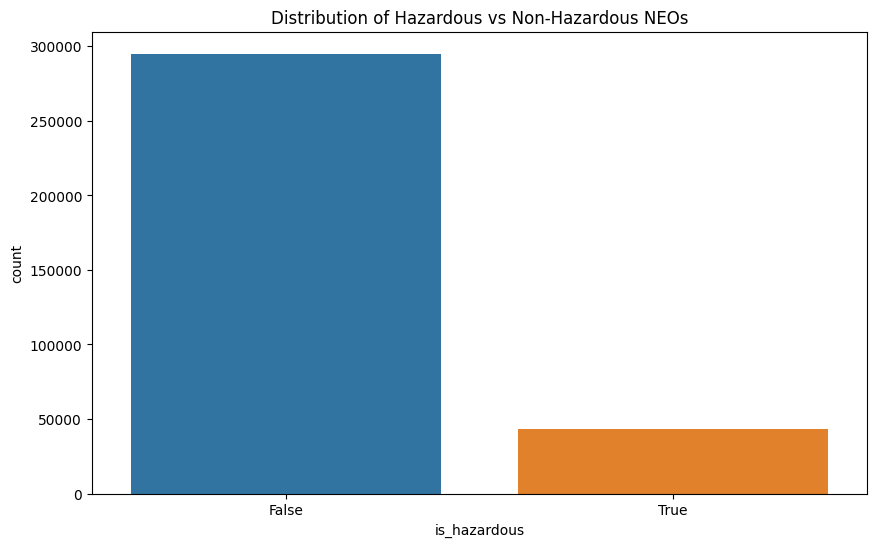

In [10]:
# Distribution of 'is_hazardous'
plt.figure(figsize=(10, 6))
sns.countplot(x='is_hazardous', data=data)
plt.title("Distribution of Hazardous vs Non-Hazardous NEOs")
plt.show()

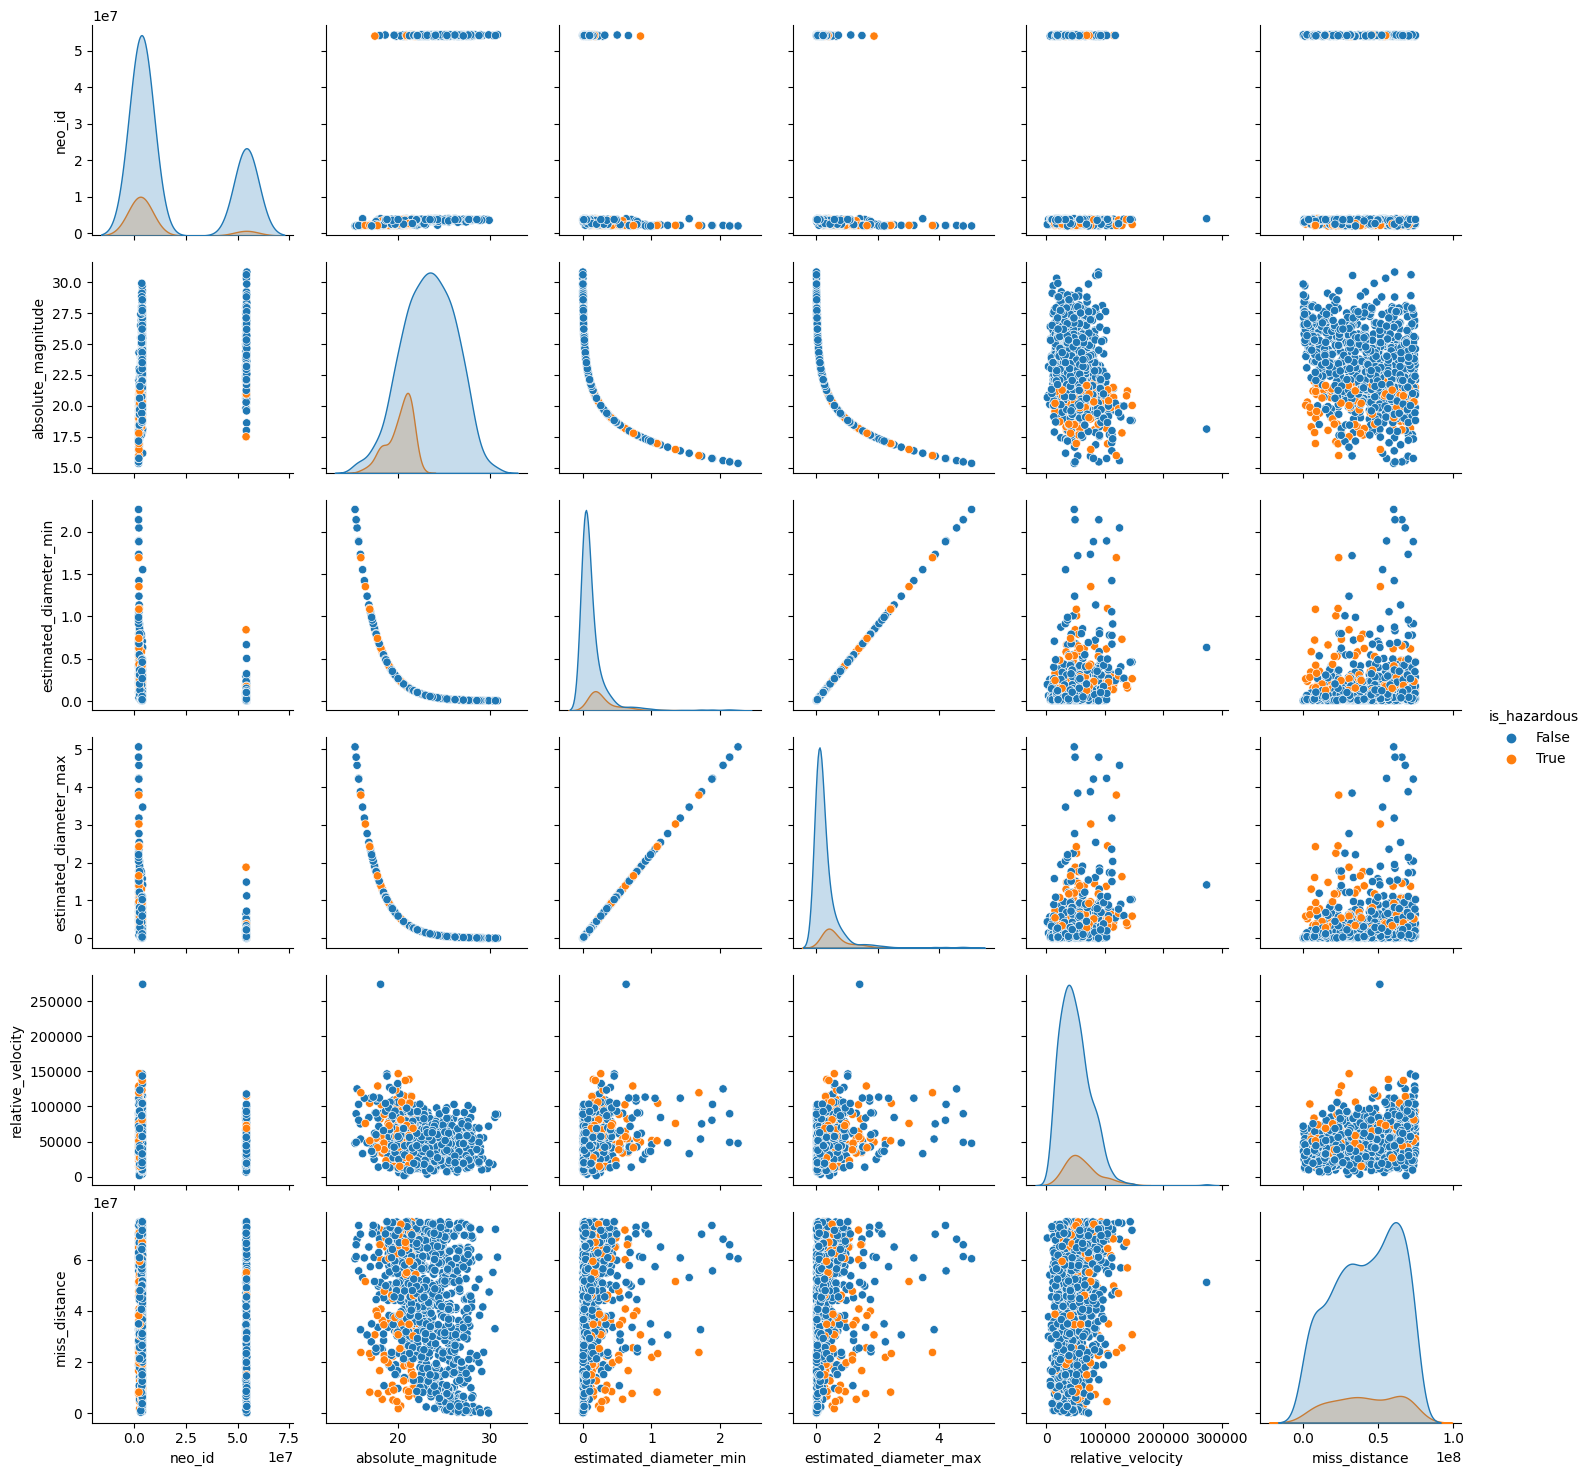

In [11]:
# Pairplot for numerical features
sns.pairplot(data.sample(1000), hue='is_hazardous', diag_kind='kde')
plt.show()

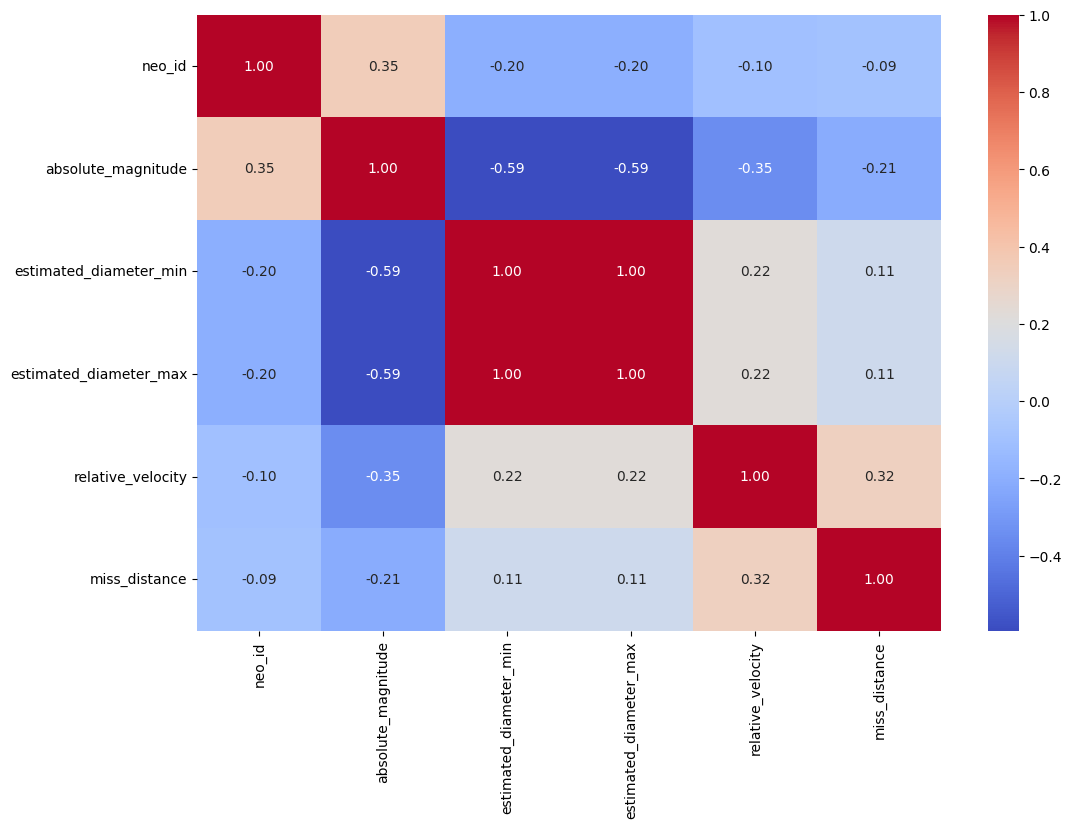

In [12]:
# Correlation heatmap
numeric_df = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

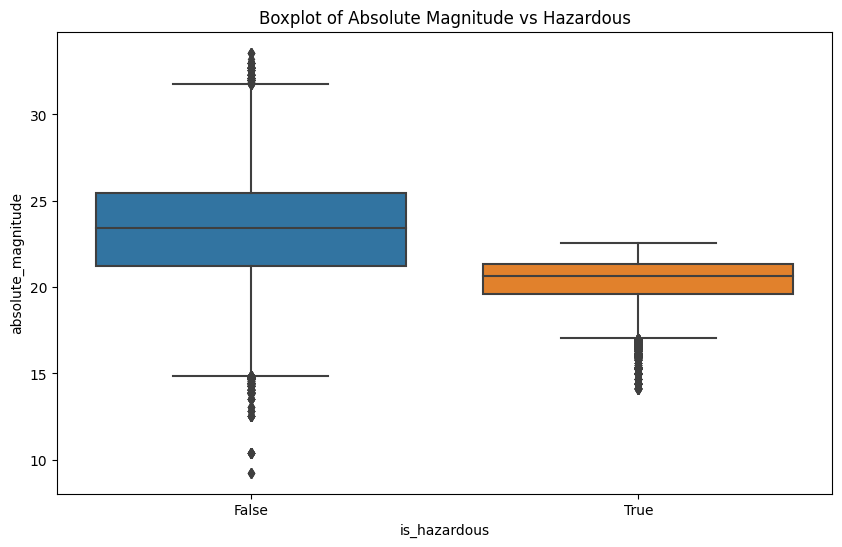

In [13]:
# Boxplot for size vs hazardous
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_hazardous', y='absolute_magnitude', data=data)
plt.title("Boxplot of Absolute Magnitude vs Hazardous")
plt.show()

# Preprocessing & Handling Imbalance

In [14]:
# Encode categorical variables if present
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    le = LabelEncoder()
    for col in categorical_cols:
        data[col] = le.fit_transform(data[col])

data.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,30603,19.14,0.394962,0.883161,0,71745.401048,5.814362e+07,False
1,2349507,31395,18.50,0.530341,1.185878,0,109949.757148,5.580105e+07,True
2,2455415,32118,21.45,0.136319,0.304818,0,24865.506798,6.720689e+07,False
3,3132126,736,20.63,0.198863,0.444672,0,78890.076805,3.039644e+07,False
4,3557844,4880,22.70,0.076658,0.171412,0,56036.519484,6.311863e+07,False


In [15]:
# Feature Selection
X = data.drop(columns=["is_hazardous"])  # Drop target column
y = data["is_hazardous"]

In [16]:
# Handling Imbalance Classes using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [17]:
# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# test_size=0.3

In [18]:
# Normalize Numerical Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training & Evaluation

## Logistic Regression

In [19]:
# Train Logistic Regression Model
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [20]:
# Evaluate Model
y_pred_lr = model_lr.predict(X_test)
y_pred_prob_lr = model_lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nLogistic Regression ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_lr))
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.72      0.79     59182
        True       0.76      0.89      0.82     58833

    accuracy                           0.81    118015
   macro avg       0.82      0.81      0.81    118015
weighted avg       0.82      0.81      0.81    118015


Logistic Regression Confusion Matrix:
 [[42535 16647]
 [ 6180 52653]]

Logistic Regression ROC AUC Score: 0.83947560273285

Logistic Regression Accuracy: 0.8065754353260178


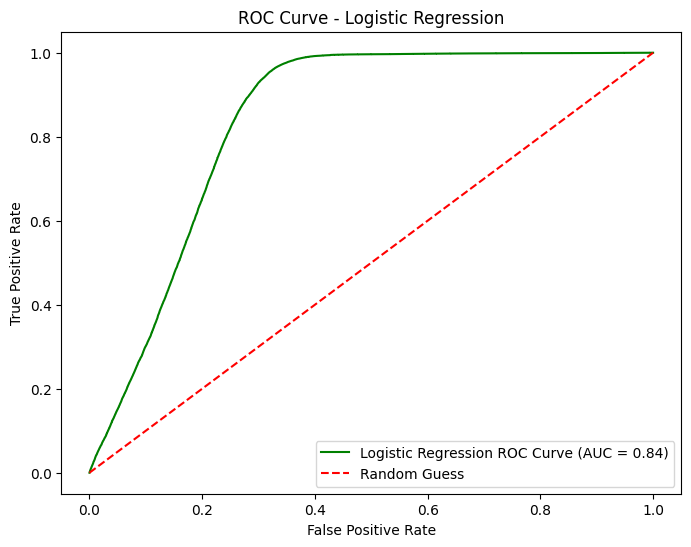

In [21]:
# Plotting the ROC Curve for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='green', label=f'Logistic Regression ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob_lr):.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

## Random Forest Classifier

In [22]:
# Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
# Evaluate Model
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99     59182
        True       0.98      0.99      0.99     58833

    accuracy                           0.99    118015
   macro avg       0.99      0.99      0.99    118015
weighted avg       0.99      0.99      0.99    118015


Confusion Matrix:
 [[58272   910]
 [  386 58447]]

ROC AUC Score: 0.9991681604122673

Random Forest Accuracy: 0.9890183451256196


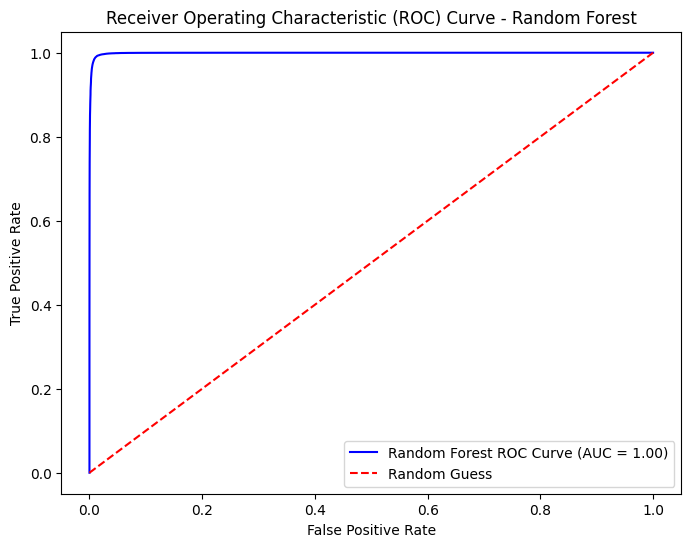

In [24]:
# Plot the ROC Curve for the Random Forest model
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

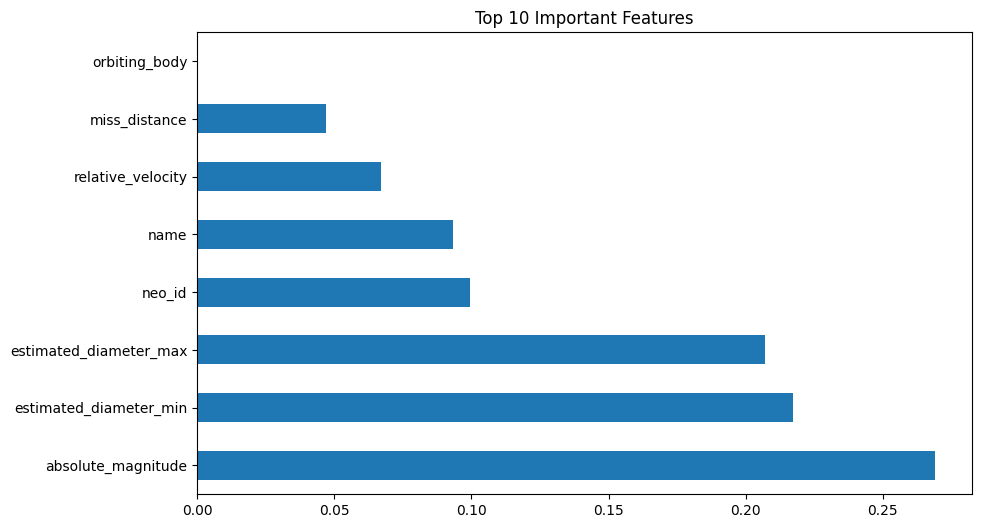

In [25]:
# Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()
